In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
user = 'admin'
password = 'admin'
host = 'localhost\SQLEXPRESS'
database = 'AdventureWorks2019'

engine = create_engine(
    'mssql+pyodbc://'
    f'{user}:{password}@{host}/{database}?' # username:pwd@server:port/database
    'TrustServerCertificate=yes&'
    'driver=ODBC+Driver+17+for+SQL+Server'
    )
#def _handle_geometry(geometry_value):
#    return f"0x{hexify(geometry_value).decode().upper()}"
#make_session = sessionmaker(engine)
#connection = engine.connect().connection
#connection.add_output_converter(-151, _handle_geometry)

In [2]:
from sqlalchemy import create_engine, MetaData
import networkx as nx
import matplotlib.pyplot as plt

query ="""
    SELECT table_name, table_schema
    FROM information_schema.tables
    WHERE table_type = 'BASE TABLE'
"""
table_names_df = pd.read_sql(query, engine)
print(table_names_df.head(5))
table_names_df.to_csv("tables_and_schemas", index=False)

         table_name table_schema
0      SalesTaxRate        Sales
1  PersonCreditCard        Sales
2       PersonPhone       Person
3    SalesTerritory        Sales
4   PhoneNumberType       Person


In [3]:
from sqlalchemy import create_engine
import pandas as pd
tables = {}
for index, row in table_names_df.iterrows():
    try:
        tables[f"{row['table_schema']}.{row['table_name']}"] = pd.read_sql(f"SELECT TOP 1 * FROM {row['table_schema']}.{row['table_name']}", engine).columns.tolist()
    except Exception as err:
        #print(err)
        print(f"ERROR: {row['table_schema']}.{row['table_name']}")
# Potential relationships
relationships = []

# Columns to ignore
ignored_columns = {"ModifiedDate", "Name", "rowguid", "StartDate", "EndDate", "Description"}
#ignored_columns = {"ModifiedDate", "Name", "rowguid", "StartDate", "EndDate", "BusinessEntityID", "Description"}
print(tables)
# Infer relationships by matching columns with similar names
for parent_table, parent_columns in tables.items():
    for child_table, child_columns in tables.items():
        if parent_table != child_table:
            for parent_col in parent_columns:
                if parent_col in ignored_columns:
                    continue  # Skip ignored columns
                for child_col in child_columns:
                    if child_col in ignored_columns:
                        continue  # Skip ignored columns
                    if parent_col == child_col:
                        if parent_col == "BusinessEntityID" or child_col == "BusinessEntityID":
                            relationship = {
                                "parent_table": parent_table,
                                "child_table": child_table,
                                "parent_column": f'{parent_table.split(".")[0]}.{parent_col}',
                                "child_column": f'{child_table.split(".")[0]}.{child_col}',
                            }
                            if f'{parent_table.split(".")[0]}.{parent_col}' == f'{child_table.split(".")[0]}.{child_col}':
                                relationships.append(relationship)
                        else:
                            relationship = {
                                "parent_table": parent_table,
                                "child_table": child_table,
                                "parent_column": parent_col,
                                "child_column": child_col,
                            }
                            relationships.append(relationship)
# Print inferred relationships
for rel in relationships:
    print(f"Parent Table: {rel['parent_table']}, Parent Column: {rel['parent_column']}")
    print(f"Child Table: {rel['child_table']}, Child Column: {rel['child_column']}")
    print("---------")

ERROR: Production.ProductDocument
ERROR: Person.Address
ERROR: Production.Document
ERROR: HumanResources.Employee
{'Sales.SalesTaxRate': ['SalesTaxRateID', 'StateProvinceID', 'TaxType', 'TaxRate', 'Name', 'rowguid', 'ModifiedDate'], 'Sales.PersonCreditCard': ['BusinessEntityID', 'CreditCardID', 'ModifiedDate'], 'Person.PersonPhone': ['BusinessEntityID', 'PhoneNumber', 'PhoneNumberTypeID', 'ModifiedDate'], 'Sales.SalesTerritory': ['TerritoryID', 'Name', 'CountryRegionCode', 'Group', 'SalesYTD', 'SalesLastYear', 'CostYTD', 'CostLastYear', 'rowguid', 'ModifiedDate'], 'Person.PhoneNumberType': ['PhoneNumberTypeID', 'Name', 'ModifiedDate'], 'Production.Product': ['ProductID', 'Name', 'ProductNumber', 'MakeFlag', 'FinishedGoodsFlag', 'Color', 'SafetyStockLevel', 'ReorderPoint', 'StandardCost', 'ListPrice', 'Size', 'SizeUnitMeasureCode', 'WeightUnitMeasureCode', 'Weight', 'DaysToManufacture', 'ProductLine', 'Class', 'Style', 'ProductSubcategoryID', 'ProductModelID', 'SellStartDate', 'SellEndD

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def generate_node_name(relationships):
    # Initialize a set of stopwords
    stop_words = set(stopwords.words('english'))

    # Collect all words from table names and column names
    words = []
    for rel in relationships:
        words.extend(rel['parent_table'].split('_'))
        words.extend(rel['child_table'].split('_'))
        if rel['parent_column']:
            words.extend(rel['parent_column'].split('_'))
        if rel['child_column']:
            words.extend(rel['child_column'].split('_'))

    # Filter out stopwords and non-alphabetic characters
    filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

    # Count the frequency of each word
    word_freq = {}
    for word in filtered_words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

    # Sort words by frequency in descending order
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    # Extract top keywords (1-3 words) for node name
    top_keywords = [word for word, freq in sorted_words[:3]]

    # Join keywords to form node name
    node_name = "_".join(top_keywords)

    return node_name

In [5]:
from pprint import pprint
# Create a dictionary to store the connections of each attribute
attribute_connections = {}

# Iterate over the relationships to identify attributes with many connections
for rel in relationships:
    parent_table = rel['parent_table']
    child_table = rel['child_table']
    parent_column = rel['parent_column']
    child_column = rel['child_column']

    # Update attribute connections for parent column
    if parent_column not in attribute_connections:
        attribute_connections[parent_column] = set()
    attribute_connections[parent_column].add(parent_table)
    attribute_connections[parent_column].add(child_table)

    # Update attribute connections for child column
    if child_column not in attribute_connections:
        attribute_connections[child_column] = set()
    attribute_connections[child_column].add(parent_table)
    attribute_connections[child_column].add(child_table)

# Identify attributes with many connections
intermediate_attributes = [attr for attr, connections in attribute_connections.items() if len(connections) > 1]

# Create a new list of relationships with intermediate nodes
relationships_with_intermediates = []

# Create a dictionary to keep track of intermediate nodes and their info
intermediate_node_info = {}

# Iterate over the relationships to add intermediate nodes
for rel in relationships:
    parent_table = rel['parent_table']
    child_table = rel['child_table']
    parent_column = rel['parent_column']
    child_column = rel['child_column']

    # Check if parent column needs an intermediate node
    if parent_column in intermediate_attributes:
        intermediate_node = child_column
        intermediate_node_info[intermediate_node] = [rel]
        relationships_with_intermediates.append({
            "parent_table": parent_table,
            "child_table": intermediate_node,
            "parent_column": parent_column,
            "child_column": intermediate_node  # No specific column for intermediate node
        })
        #print(intermediate_node)
        parent_table = intermediate_node

    # Check if child column needs an intermediate node
    if child_column in intermediate_attributes:
        intermediate_node = parent_column
        if intermediate_node in intermediate_node_info:
            intermediate_node_info[intermediate_node].append(rel)
        else:
            intermediate_node_info[intermediate_node] = [rel]
        relationships_with_intermediates.append({
            "parent_table": intermediate_node,
            "child_table": child_table,
            "parent_column": intermediate_node,  # No specific column for intermediate node
            "child_column": child_column
        })
        #print(intermediate_node)
        child_table = intermediate_node

    # Add the modified relationship
    relationships_with_intermediates.append({
        "parent_table": parent_table,
        "child_table": child_table,
        "parent_column": parent_column,
        "child_column": child_column
    })
#pprint(intermediate_node_info)
# Add relationships between original nodes and intermediate nodes
for intermediate_node, node_info in intermediate_node_info.items():
    for rel in relationships_with_intermediates:
        if rel['parent_table'] != intermediate_node and rel['child_table'] != intermediate_node:
            if rel in node_info:
                relationships_with_intermediates.append({
                    "parent_table": rel['parent_table'],
                    "child_table": rel['parent_column'],
                    "parent_column": rel['parent_column'],
                    "child_column": rel['parent_table'],  # No specific column for intermediate node
                })
                relationships_with_intermediates.append({
                    "parent_table": rel['child_column'],
                    "child_table": rel['child_table'],
                    "parent_column": rel['child_table'],  # No specific column for intermediate node
                    "child_column": rel['child_column']
                })
#relationships =relationships + relationships_with_intermediates
relationships = relationships_with_intermediates
# Print inferred relationships
for rel in relationships:
    print(f"Parent Table: {rel['parent_table']}, Parent Column: {rel['parent_column']}")
    print(f"Child Table: {rel['child_table']}, Child Column: {rel['child_column']}")
    print("---------")


Parent Table: Sales.SalesTaxRate, Parent Column: StateProvinceID
Child Table: StateProvinceID, Child Column: StateProvinceID
---------
Parent Table: StateProvinceID, Parent Column: StateProvinceID
Child Table: Person.StateProvince, Child Column: StateProvinceID
---------
Parent Table: StateProvinceID, Parent Column: StateProvinceID
Child Table: StateProvinceID, Child Column: StateProvinceID
---------
Parent Table: Sales.PersonCreditCard, Parent Column: Sales.BusinessEntityID
Child Table: Sales.BusinessEntityID, Child Column: Sales.BusinessEntityID
---------
Parent Table: Sales.BusinessEntityID, Parent Column: Sales.BusinessEntityID
Child Table: Sales.SalesTerritoryHistory, Child Column: Sales.BusinessEntityID
---------
Parent Table: Sales.BusinessEntityID, Parent Column: Sales.BusinessEntityID
Child Table: Sales.BusinessEntityID, Child Column: Sales.BusinessEntityID
---------
Parent Table: Sales.PersonCreditCard, Parent Column: Sales.BusinessEntityID
Child Table: Sales.BusinessEntityID

Number of nodes: 130
Number of edges: 168
['dbo.DatabaseLog', 'dbo.ErrorLog', 'dbo.AWBuildVersion']


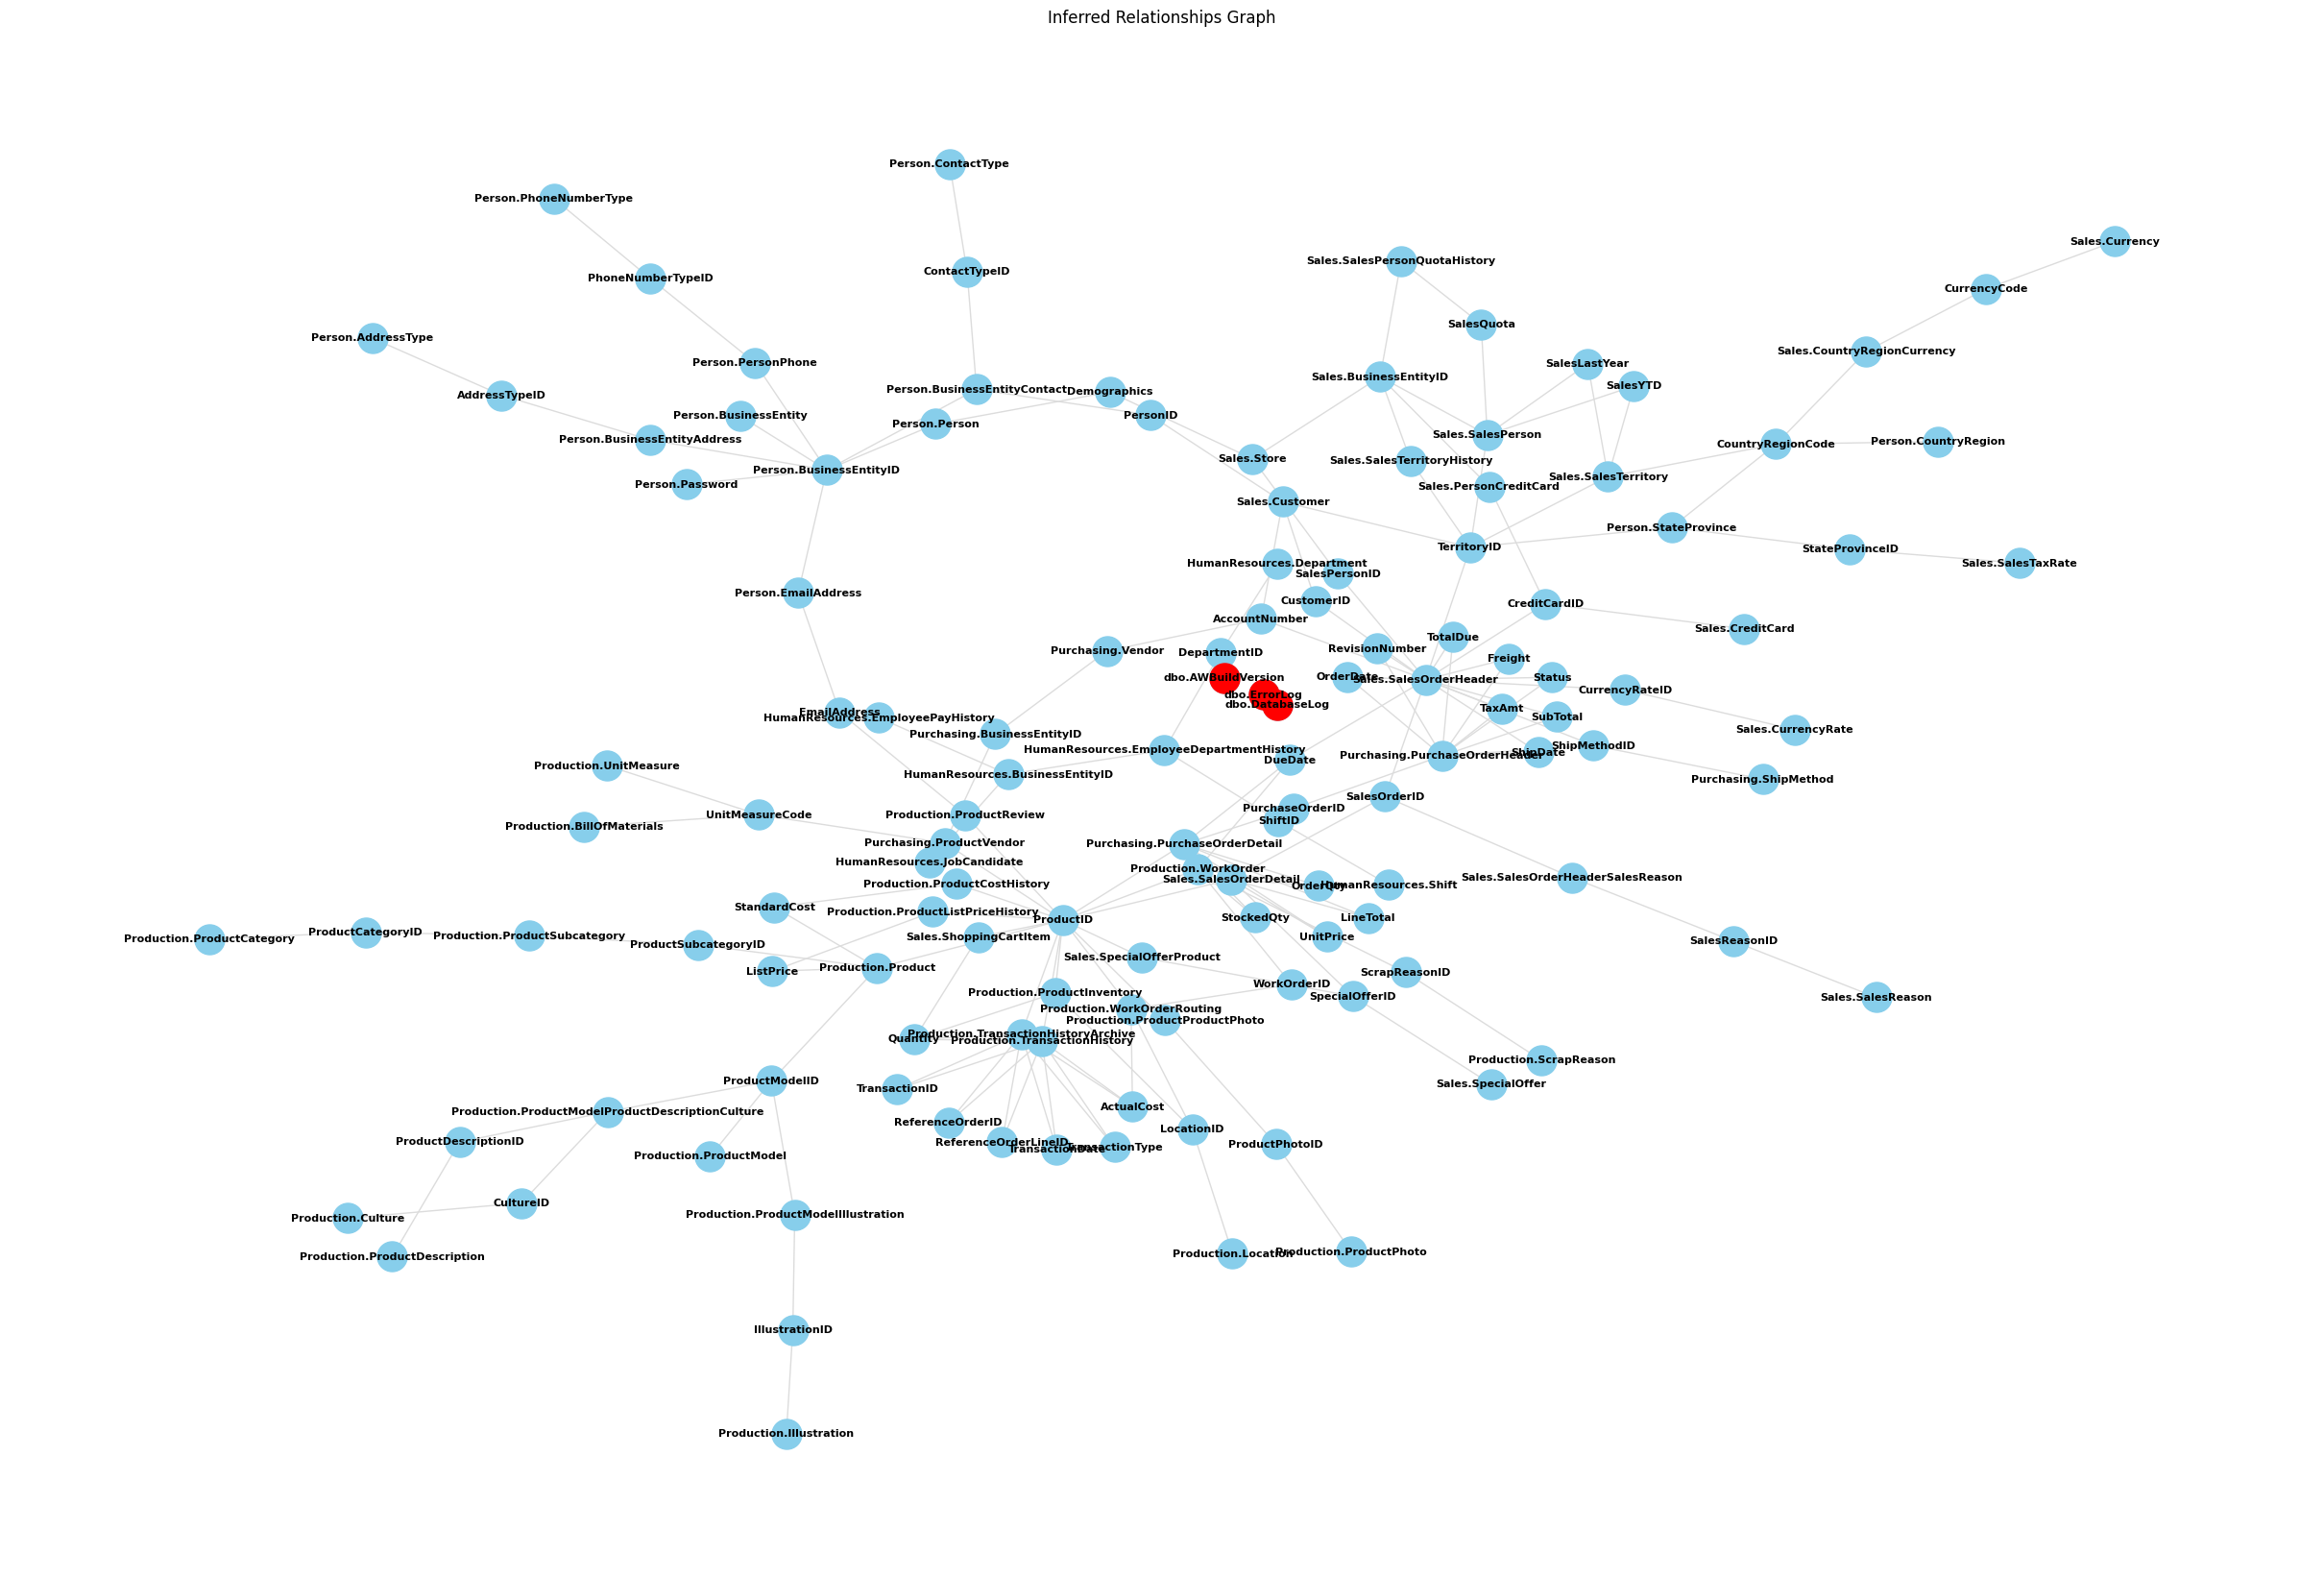

In [6]:
import networkx as nx

# Create a graph
G = nx.DiGraph()

# Add nodes for each table
for table in tables.keys():
    G.add_node(table)

for rel in relationships:
    parent = rel['parent_table']
    child = rel['child_table']
    
    # Ensure that parent and child are not the same
    if parent != child:
        edge_label = f"{rel['parent_column']} -> {rel['child_column']}"
        if G.has_edge(parent, child):
            # If the edge already exists, replace the label
            G[parent][child]['label'] = edge_label
        else:
            G.add_edge(parent, child, label=edge_label)

G=G.to_undirected()

# Count the number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

pos = nx.kamada_kawai_layout(G)  # positions for all nodes
#pos = nx.spring_layout(G, scale = 5, iterations=500, k= 4) 
# Identify isolated nodes
isolated_nodes = list(nx.isolates(G))
print(isolated_nodes)

plt.figure(figsize=(24, 16))
nx.draw(G, pos, edge_color="gainsboro", with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold')
nx.draw_networkx_nodes(G, pos, nodelist=isolated_nodes, node_color='red', node_size=500)
#edge_labels = nx.get_edge_attributes(G, 'label')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
plt.title("Inferred Relationships Graph")
plt.show()


Save graph for further usage

In [7]:
import pickle
with open('adw_graph_degree_2.pickle', 'wb') as f:
    pickle.dump(G, f)

In [8]:
import matplotlib
import matplotlib.pyplot as plt
from networkx.algorithms import approximation
from networkx.algorithms import community

node_eigenvector = nx.eigenvector_centrality(G, max_iter=10000)
sorted((f"{c:0.3f}", v) for v, c in node_eigenvector.items())

[('0.000', 'AddressTypeID'),
 ('0.000', 'DepartmentID'),
 ('0.000', 'HumanResources.BusinessEntityID'),
 ('0.000', 'HumanResources.Department'),
 ('0.000', 'HumanResources.EmployeeDepartmentHistory'),
 ('0.000', 'HumanResources.EmployeePayHistory'),
 ('0.000', 'HumanResources.JobCandidate'),
 ('0.000', 'HumanResources.Shift'),
 ('0.000', 'Person.AddressType'),
 ('0.000', 'Person.BusinessEntity'),
 ('0.000', 'Person.BusinessEntityAddress'),
 ('0.000', 'Person.ContactType'),
 ('0.000', 'Person.Password'),
 ('0.000', 'Person.PersonPhone'),
 ('0.000', 'Person.PhoneNumberType'),
 ('0.000', 'PhoneNumberTypeID'),
 ('0.000', 'Production.Culture'),
 ('0.000', 'Production.Illustration'),
 ('0.000', 'Production.ProductCategory'),
 ('0.000', 'Production.ProductDescription'),
 ('0.000', 'Sales.Currency'),
 ('0.000', 'ShiftID'),
 ('0.000', 'dbo.AWBuildVersion'),
 ('0.000', 'dbo.DatabaseLog'),
 ('0.000', 'dbo.ErrorLog'),
 ('0.001', 'ContactTypeID'),
 ('0.001', 'CultureID'),
 ('0.001', 'CurrencyCode')

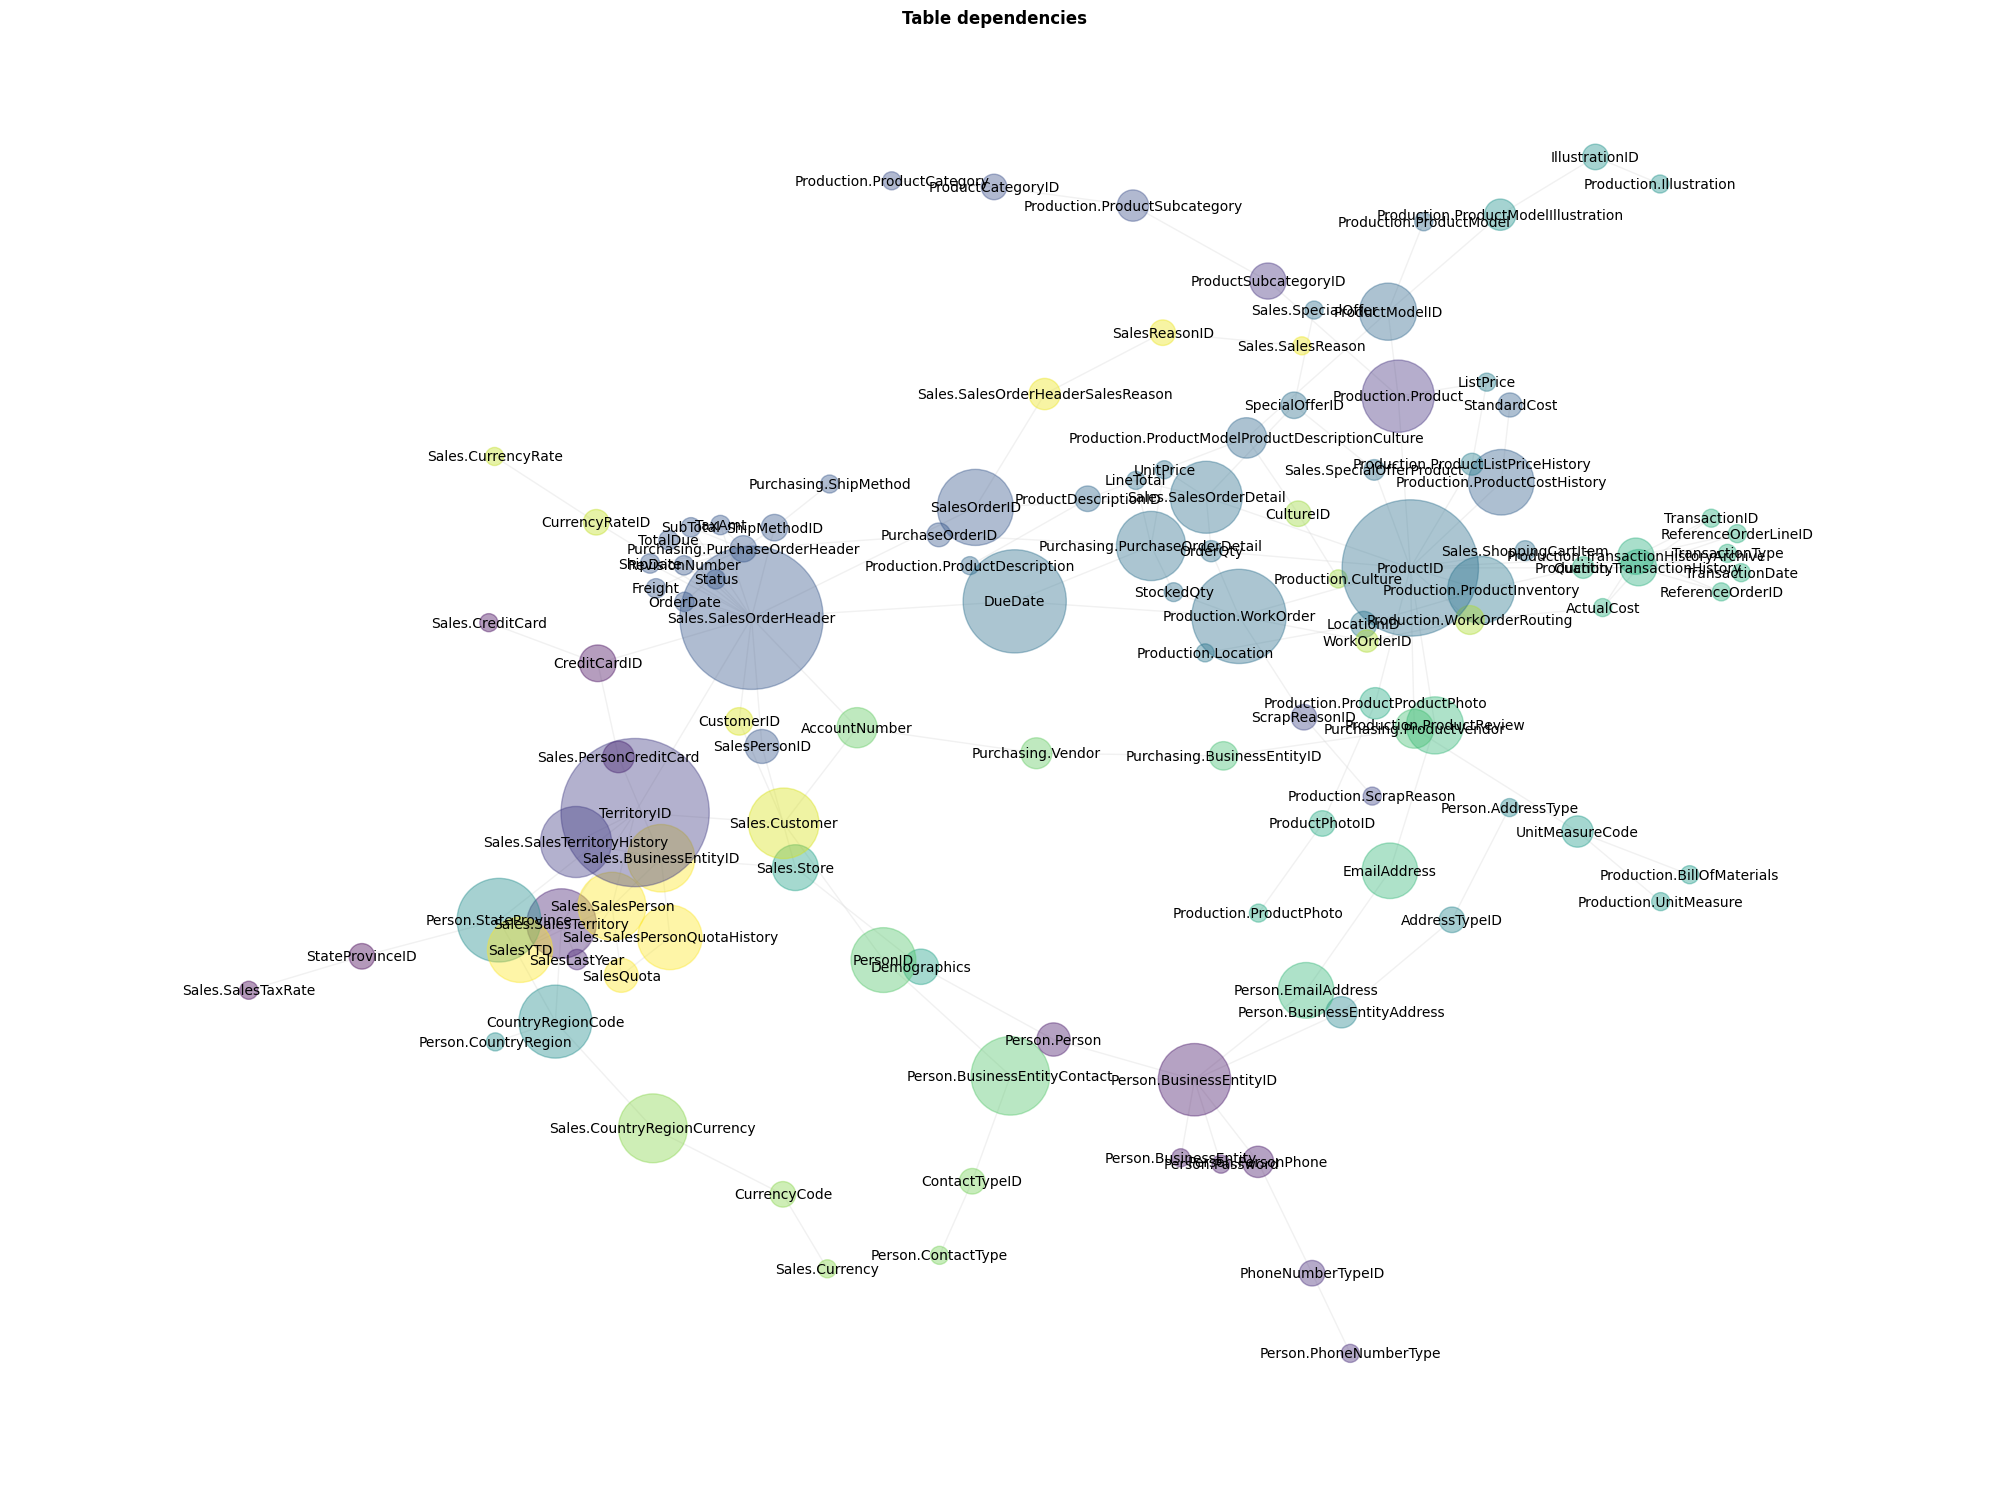

In [9]:
# largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)
# compute centrality
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)
# compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)
nx.draw_networkx_labels(H, pos, font_size=10)
# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 12}
ax.set_title("Table dependencies", font)
# Change font color for legend
font["color"] = "r"


# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()